In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/ERIN_LEE/BCa

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1z9Wb5oKhSHgPEN6aNZnaRXreqmpTD47M/BCa


In [2]:
!ls

AASCII.csv  ds_AASCII_fixed.zip  ds_HASCII_fixed.zip  HASCII.csv  SokolovDemidenko_PNAS.pdf


In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_AASCII = pd.read_csv('AASCII.csv')
df_HASCII = pd.read_csv('HASCII.csv')

In [5]:
df_AASCII = df_AASCII.T
df_HASCII = df_HASCII.T

In [6]:
df_AASCII.drop([0,2],axis=1,inplace=True)
df_HASCII.drop([0,2],axis=1,inplace=True)

In [7]:
df_AASCII.reset_index(drop=True,inplace=True)
df_HASCII.reset_index(drop=True,inplace=True)

In [8]:
X_AASCII = df_AASCII.drop(columns=[1])
y_AASCII = df_AASCII[1].astype(int)
X_HASCII = df_HASCII.drop(columns=[1])
y_HASCII = df_HASCII[1].astype(int)

In [9]:
# merge class 1 and 2
y_AASCII = y_AASCII.replace([2],[1])
y_HASCII = y_HASCII.replace([2],[1])

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

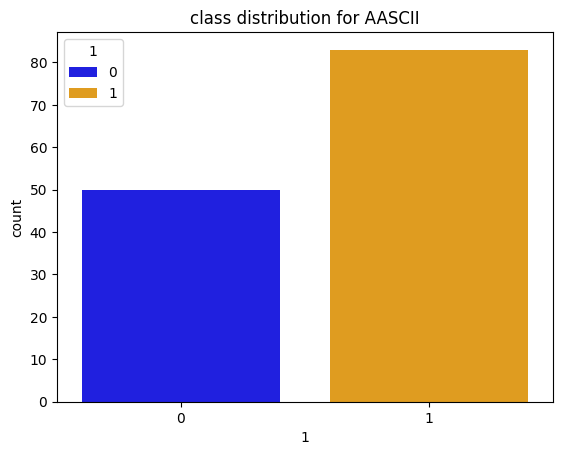

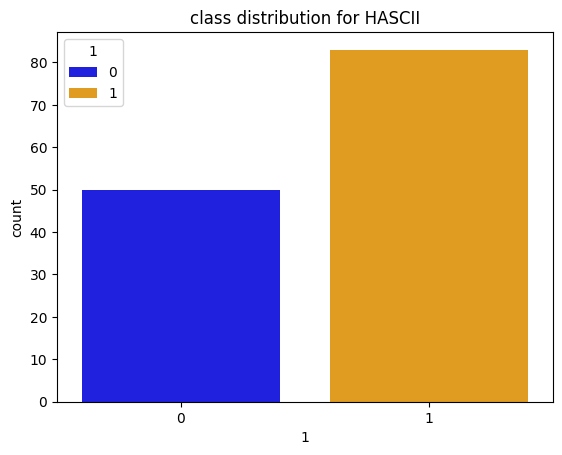

In [11]:
colors = ['blue', 'orange', 'green']
sns.countplot(x=y_AASCII,palette=colors,hue=y_AASCII)
plt.title('class distribution for AASCII')
plt.show()

sns.countplot(x=y_HASCII,palette=colors,hue=y_HASCII)
plt.title('class distribution for HASCII')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X_AASCII, y_AASCII, test_size=0.30, random_state=42)
X_trainH, X_testH, y_trainH, y_testH = train_test_split(X_HASCII, y_HASCII,test_size=0.30, random_state=42)

In [14]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import model_selection
from xgboost.sklearn import XGBClassifier
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

MLA = [
    ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0),
    svm.SVC(probability=True),
    tree.DecisionTreeClassifier(),
    XGBClassifier(n_jobs=-1),
    linear_model.LogisticRegressionCV(),
    linear_model.Perceptron()
]

MLA_columns = ['MLA_names', 'MLA_parameters', 'MLA_Train_Accuracy_Mean'
               ,'MLA_Test_Accuracy_Mean', 'MLA_Test_Accuracy_3*STD',
               'MLA_Time']

def apply_models(X_train,y_train,X_test,y_test):
  MLA_compare = pd.DataFrame(columns = MLA_columns)

  MLA_Predict = y_test.copy()
  row_index = 0
  for alg in tqdm(MLA):
      try:
          MLA_name = alg.__class__.__name__
          MLA_compare.loc[row_index, 'MLA_names'] = MLA_name
          MLA_compare.loc[row_index, 'MLA_parameters'] = str(alg.get_params())
          cv_results = model_selection.cross_validate(alg, X_train, y_train, cv=3, return_train_score = True)
          MLA_compare.loc[row_index, 'MLA_Time'] = cv_results['fit_time'].mean()
          MLA_compare.loc[row_index, 'MLA_Train_Accuracy_Mean'] = cv_results["train_score"].mean()
          MLA_compare.loc[row_index, 'MLA_Test_Accuracy_Mean'] = cv_results['test_score'].mean()
          MLA_compare.loc[row_index, 'MLA_Test_Accuracy_3*STD'] = cv_results['test_score'].std()*3

          alg.fit(X_train, y_train)
          MLA_Predict[MLA_name] = alg.predict(X_test)
          row_index += 1
          print(".", end="")
      except:
          print(type(alg).__name__)
  MLA_compare.sort_values(by = 'MLA_Test_Accuracy_Mean', ascending = False, inplace = True)
  return MLA_compare

In [15]:
apply_models(X_trainA,y_trainA,X_testA,y_testA)

  0%|          | 0/6 [00:00<?, ?it/s]

......

,MLA_names,MLA_parameters,MLA_Train_Accuracy_Mean,MLA_Test_Accuracy_Mean,MLA_Test_Accuracy_3*STD,MLA_Time
2,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.623656,0.120699,5.124237
1,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.677419,0.612903,0.079016,3.367598
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.591398,0.09124,1.946818
3,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",1.0,0.55914,0.241397,102.663628
4,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",1.0,0.537634,0.120699,148.37674
5,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.833333,0.387097,0.136859,1.481251


In [16]:
apply_models(X_trainH,y_trainH,X_testH,y_testH)

  0%|          | 0/6 [00:00<?, ?it/s]

......

,MLA_names,MLA_parameters,MLA_Train_Accuracy_Mean,MLA_Test_Accuracy_Mean,MLA_Test_Accuracy_3*STD,MLA_Time
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.569892,0.120699,1.79084
5,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.983871,0.569892,0.277494,1.630594
1,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.795699,0.55914,0.164485,3.585094
4,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",1.0,0.55914,0.164485,80.110178
2,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.494624,0.182479,5.724421
3,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",1.0,0.483871,0.209056,104.656819
